In [13]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [14]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: 无法创建目录"/home/aistudio/external-libraries": 文件已存在
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/69/bf/f0f194d3379d3f3347478bd267f754fc68c11cbf2fe302a6ab69447b1417/beautifulsoup4-4.10.0-py3-none-any.whl (97 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/72/a6/fd01694427f1c3fcadfdc5f1de901b813b9ac756f0806ef470cfed1de281/soupsieve-2.3.1-py3-none-any.whl (37 kB)
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [1]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [2]:
!nvidia-smi

Sun Mar  6 20:00:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:09.0 Off |                    0 |
| N/A   38C    P0    41W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import paddle
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np

paddle.__version__, paddle.device.get_device()

('2.2.2', 'gpu:0')

### Data loading and preprocessing

In [5]:
import paddle.vision.transforms as T
from paddle.vision.datasets import FashionMNIST

# loading and normalization
transform = T.Normalize(mean=[127.5], std=[127.5])  

# constructing traning set and test set
fashionmnist_train = FashionMNIST(mode='train', transform=transform)
fashionmnist_test = FashionMNIST(mode='test', transform=transform)

In [6]:
# nums of train set and test set
len(fashionmnist_train), len(fashionmnist_test)


(60000, 10000)

In [7]:
# As for one sample, channel = 1, height, weight = 28
fashionmnist_train[0][0].shape

(1, 28, 28)

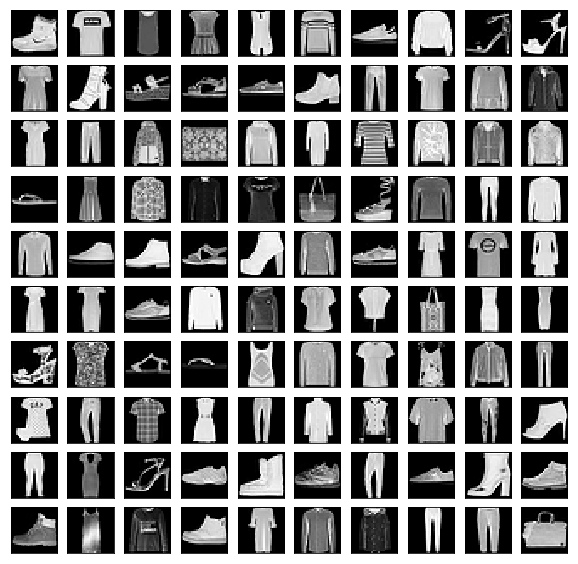

In [9]:
# show 100 images in train set
plt.figure(figsize=(10, 10))

for idx in range(100):
    xy = fashionmnist_train[idx][0].reshape(28, 28)
    plt.subplot(10, 10, idx + 1)
    plt.imshow(xy, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [11]:
# X, y = next(iter(paddle.io.DataLoader(fashionmnist_train, batch_size=64, shuffle=True)))
# X.shape, y.shape

In [10]:
train_loader = paddle.io.DataLoader(fashionmnist_train, batch_size=256, shuffle=True)
test_loader = paddle.io.DataLoader(fashionmnist_test, batch_size=64, shuffle=False)

### Model

In [11]:
import paddle.nn as nn

class lenet(nn.Layer):
    def __init__(self):
        super(lenet, self).__init__()
        self.act = nn.Sigmoid()

        self.conv1 = nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2D(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2D(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = nn.Linear(in_features=120, out_features=84)
        self.linear3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, input):
        x = self.act(self.conv1(input))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        output = self.linear3(x)
        return output

In [13]:
# instantiation
net = lenet()
model = paddle.Model(net)

# visualization of the model workflow
model.summary((-1, 1, 28, 28)) # [N C H W]

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-3       [[1, 1, 28, 28]]      [1, 6, 28, 28]          156      
   Sigmoid-2         [[1, 84]]             [1, 84]               0       
  AvgPool2D-3     [[1, 6, 28, 28]]      [1, 6, 14, 14]           0       
   Conv2D-4       [[1, 6, 14, 14]]     [1, 16, 10, 10]         2,416     
  AvgPool2D-4    [[1, 16, 10, 10]]      [1, 16, 5, 5]            0       
   Flatten-2      [[1, 16, 5, 5]]          [1, 400]              0       
   Linear-4          [[1, 400]]            [1, 120]           48,120     
   Linear-5          [[1, 120]]            [1, 84]            10,164     
   Linear-6          [[1, 84]]             [1, 10]              850      
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

{'total_params': 61706, 'trainable_params': 61706}

### Training

In [14]:
model.prepare(optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=1e-4),
              loss=nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())

# training
model.fit(train_loader,
        # eval_data = test_loader
        epochs=30,
        verbose=1,
        )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/30


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 235/235 [==============================] - loss: 2.2856 - acc: 0.1357 - 26ms/step          
Epoch 2/30
step 235/235 [==============================] - loss: 1.9725 - acc: 0.3234 - 26ms/step          
Epoch 3/30
step 235/235 [==============================] - loss: 1.5278 - acc: 0.5001 - 25ms/step          
Epoch 4/30
step 235/235 [==============================] - loss: 1.3251 - acc: 0.5719 - 25ms/step          
Epoch 5/30
step 235/235 [==============================] - loss: 1.2098 - acc: 0.6051 - 24ms/step          
Epoch 6/30
step 235/235 [==============================] - loss: 0.9645 - acc: 0.6330 - 31ms/step          
Epoch 7/30
step 235/235 [==============================] - loss: 0.9808 - acc: 0.6632 - 26ms/step          
Epoch 8/30
step 235/235 [==============================] - loss: 0.9791 - acc: 0.6817 - 25ms/step          
Epoch 9/30
step 235/235 [==============================] - loss: 0.8584 - acc: 0.6946 - 25ms/step          
Epoch 10/30
step 235/235 [=============

In [15]:
model.evaluate(fashionmnist_test, verbose=1)

Eval begin...
step 10000/10000 [==============================] - loss: 0.1401 - acc: 0.7721 - 3ms/step          
Eval samples: 10000


{'loss': [0.14012995], 'acc': 0.7721}